<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/triangles/triangles_Silhouette_validation_DINOV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
# Load DINOv2
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dinov2_vits14.to(device).eval()

# Transform definitions
class PadToCenter224:
    def __call__(self, img):
        w, h = img.size
        scale = min(224/w, 224/h, 1.0)
        new_w, new_h = int(w*scale), int(h*scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        canvas = Image.new("RGB",(224,224)); canvas.paste(img, ((224-new_w)//2,(224-new_h)//2))
        return canvas

# Factory for resize+pad
def resize_and_pad(size):
    class Mod:
        def __call__(self, img):
            img = img.resize((size,size), Image.BICUBIC)
            canvas = Image.new("RGB",(224,224)); canvas.paste(img,((224-size)//2,(224-size)//2))
            return canvas
    return Mod()

class Duplicate2x2Grid:
    def __call__(self, img):
        w,h = img.size
        grid = Image.new("RGB",(w*2,h*2))
        for i in range(2):
            for j in range(2): grid.paste(img,(i*w,j*h))
        return grid.resize((224,224), Image.BICUBIC)

normalize = T.Compose([T.ToTensor(), T.Normalize([0.5]*3,[0.5]*3)])
transforms_dict = {
    "pad_center_224": T.Compose([PadToCenter224(), normalize]),
    "resize_224": T.Compose([T.Resize((224,224)), normalize]),
    "resize_100_pad": T.Compose([resize_and_pad(100), normalize]),
    "resize_150_pad": T.Compose([resize_and_pad(150), normalize]),
    "resize_200_pad": T.Compose([resize_and_pad(200), normalize]),
    "resize_50_pad": T.Compose([resize_and_pad(50), normalize]),
    "grid_2x2": T.Compose([Duplicate2x2Grid(), normalize]),
}

# Utils
def get_image_paths(dirpath):
    out=[]
    for cl in os.listdir(dirpath):
        cp=os.path.join(dirpath,cl)
        if os.path.isdir(cp):
            out += [os.path.join(cp,f) for f in os.listdir(cp) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    return out

def extract_embeddings(paths, transform):
    X, y = [], []
    with torch.no_grad():
        for p in tqdm(paths):
            img=Image.open(p).convert("RGB")
            emb = dinov2_vits14(transform(img).unsqueeze(0).to(device))[0]
            X.append(emb.cpu().numpy().reshape(-1))
            y.append(os.path.basename(os.path.dirname(p)))
    return np.array(X), np.array(y)

def compute_sep(X,y):
    cen=[X[y==c].mean(0) for c in np.unique(y)]
    d=[np.linalg.norm(cen[i]-cen[j]) for i in range(len(cen)) for j in range(i) ]
    return np.mean(d)

# Load train set
train_paths = get_image_paths("/content/drive/MyDrive/triangle_truncated_circle_small/train")
results_train = []
train_embeddings = {}
for name, tf in transforms_dict.items():
    X,y = extract_embeddings(train_paths, tf)
    train_embeddings[name] = (X, y)
    sil = silhouette_score(X,y)
    sep = compute_sep(X,y)
    results_train.append({"Transform":name,"Silhouette":sil,"Separation":sep})
df_train = pd.DataFrame(results_train).sort_values(by="Silhouette",ascending=False)
print("\nTraining Metrics:\n", df_train.to_string(index=False, float_format="%.3f"))

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:02<00:00, 131MB/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


Training Metrics:
      Transform  Silhouette  Separation
 resize_50_pad       0.196      15.669
resize_150_pad       0.184      19.887
    resize_224       0.170      20.634
resize_200_pad       0.164      20.222
resize_100_pad       0.157      17.805
pad_center_224       0.139      18.220
      grid_2x2       0.138      18.390


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# בחר את השם של ההכנה שאתה רוצה לבדוק
chosen_transform_name = "resize_224"  # <-- שנה כאן לפי הצורך

# הגדר מודלים ופרמטרים
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}),
    "NaiveBayes": (GaussianNB(), {})
}

# טען נתוני אימון והמר labels
X_train, y_train = train_embeddings[chosen_transform_name]
val_paths = get_image_paths("/content/drive/MyDrive/triangle_truncated_circle_small/validation")
X_val, y_val = extract_embeddings(val_paths, transforms_dict[chosen_transform_name])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

val_results = []
best_params = {}

print(f"\nRunning validation for transform: {chosen_transform_name}")
for clf_name, (clf, grid) in classifiers.items():
    if grid:
        gs = GridSearchCV(clf, grid, cv=3, scoring="accuracy")
        gs.fit(X_train, y_train_enc)
        best = gs.best_estimator_
        best_params[clf_name] = gs.best_params_
    else:
        best = clf.fit(X_train, y_train_enc)
        best_params[clf_name] = {}

    y_pred = best.predict(X_val)
    acc = accuracy_score(y_val_enc, y_pred)
    min_cls = np.bincount(y_val_enc).argmin()
    f1_min = f1_score(y_val_enc, y_pred, labels=[min_cls], average="macro")

    val_results.append({
        "Model": clf_name,
        "Accuracy": acc,
        "F1_Minority": f1_min
    })

# הצגת טבלה מסכמת
df_val = pd.DataFrame(val_results)
df_val.set_index("Model", inplace=True)
print("\nValidation Results for transform:", chosen_transform_name)
print(df_val.round(3).to_string())

# הדפסת הפרמטרים האופטימליים
print("\nBest hyperparameters:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")


  0%|          | 0/19 [00:00<?, ?it/s]


Running validation for transform: resize_224

Validation Results for transform: resize_224
                    Accuracy  F1_Minority
Model                                    
LogisticRegression     0.842        0.769
SVM                    0.789        0.667
RandomForest           0.842        0.800
NaiveBayes             0.789        0.714

Best hyperparameters:
LogisticRegression: {'C': 0.01, 'penalty': 'l2'}
SVM: {'C': 10, 'gamma': 'scale'}
RandomForest: {'max_depth': None, 'n_estimators': 50}
NaiveBayes: {}


In [ ]:
def visualize_predictions_with_bboxes(full_image_path, file_paths, predicted_labels, save_path):
    """
    מציירת תיבות סביב האובייקטים בתמונה לפי התחזיות של המודל.

    Parameters:
    - full_image_path: str, הנתיב לתמונה המלאה (background)
    - file_paths: list of str, מסלולים לתמונות החתוכות (שמות כוללים קואורדינטות)
    - predicted_labels: list of str/int, התחזיות (labels) של המודל
    - save_path: str, הנתיב לשמירת התמונה עם התיבות
    """
    import cv2
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    full_image = cv2.imread(full_image_path)
    image_copy = full_image.copy()
    pattern = re.compile(r"triangle_test_(\d+)_(\d+)_(\d+)_(\d+)\.jpg")

    unique_labels = list(set(predicted_labels))
    colors = {}

    color_palette = [
        (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
        (255, 0, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0),
    ]

    for i, label in enumerate(unique_labels):
        colors[label] = color_palette[i % len(color_palette)]

    legend_height = 30 * len(unique_labels)
    legend_width = 200
    legend_img = np.ones((legend_height, legend_width, 3), dtype=np.uint8) * 255

    for i, label in enumerate(unique_labels):
        color = colors[label]
        cv2.rectangle(legend_img, (10, i*30 + 10), (30, i*30 + 30), color, -1)
        cv2.putText(legend_img, f"Class {label}", (40, i*30 + 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    for file_path, label in zip(file_paths, predicted_labels):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            x1, y1, x2, y2 = map(int, match.groups())
            color = colors[label]
            overlay = image_copy.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 1)
            alpha = 1.4
            cv2.addWeighted(overlay, alpha, image_copy, 1 - alpha, 0, image_copy)

    cv2.imwrite(save_path, image_copy)
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    legend_rgb = cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]})
    ax[0].imshow(image_rgb)
    ax[0].set_title("Image with Bounding Boxes")
    ax[0].axis('off')

    ax[1].imshow(legend_rgb)
    ax[1].set_title("Class Legend")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Saved image with bounding boxes to: {save_path}")


  0%|          | 0/105 [00:00<?, ?it/s]

<Figure size 600x500 with 0 Axes>

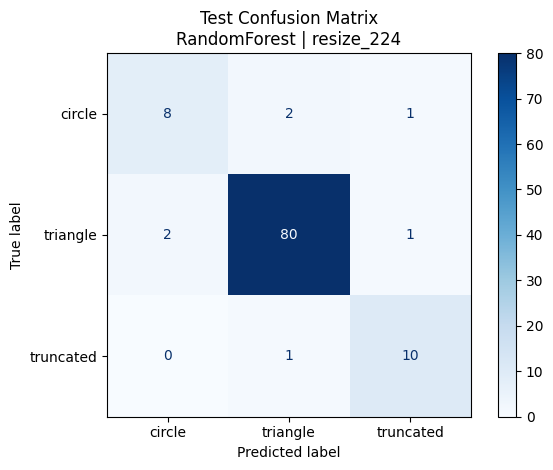


Classification Report for RandomForest | resize_224:

              precision    recall  f1-score   support

      circle       0.80      0.73      0.76        11
    triangle       0.96      0.96      0.96        83
   truncated       0.83      0.91      0.87        11

    accuracy                           0.93       105
   macro avg       0.87      0.87      0.87       105
weighted avg       0.93      0.93      0.93       105



In [ ]:
def evaluate_on_test(transform_name, model_name):
    tf = transforms_dict[transform_name]
    X_train, y_train = train_embeddings[transform_name]
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)

    clf, _grid = classifiers[model_name]
    params = best_params.get((transform_name, model_name), {})
    clf.set_params(**params)
    clf.fit(X_train, y_train_enc)

    # test embeddings
    test_paths = get_image_paths("/content/drive/MyDrive/triangle_truncated_circle_small/test")
    X_test, y_test = extract_embeddings(test_paths, tf)
    y_test_enc = le.transform(y_test)

    # Predictions
    y_pred = clf.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    plt.figure(figsize=(6,5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Test Confusion Matrix\n{model_name} | {transform_name}")
    plt.tight_layout()
    plt.show()

    # Classification Report
    report = classification_report(y_test_enc, y_pred, target_names=le.classes_)
    print(f"\nClassification Report for {model_name} | {transform_name}:\n")
    print(report)


# Example usage:
evaluate_on_test("resize_224", "RandomForest")